In [1]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from pandas_datareader.data import DataReader
import os
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from xgboost import XGBRegressor
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
df = pd.read_csv(r'..\stocks\AAPL.csv', index_col=['Date'], parse_dates=['Date'])
df = df.dropna()

# Select the proper time period for daily aggreagation
df = df['2019-01-02':'2020-12-05'].resample('D').sum()
df.head()

High        Low       Open      Close       Volume  Adj Close
Date                                                                          
2019-01-02  39.712502  38.557499  38.722500  39.480000  148158800.0  38.505024
2019-01-03  36.430000  35.500000  35.994999  35.547501  365248800.0  34.669640
2019-01-04  37.137501  35.950001  36.132500  37.064999  234428400.0  36.149662
2019-01-05   0.000000   0.000000   0.000000   0.000000          0.0   0.000000
2019-01-06   0.000000   0.000000   0.000000   0.000000          0.0   0.000000

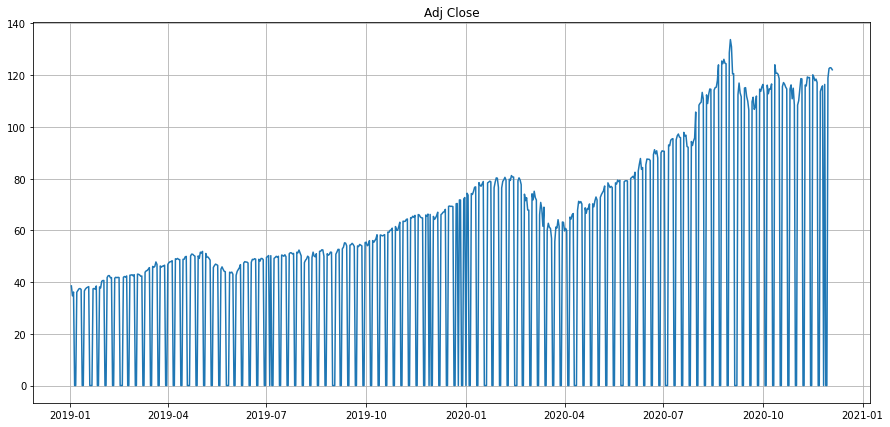

In [3]:
adj_close = df['Adj Close']
plt.figure(figsize=(15, 7))
plt.plot(df['Adj Close'])
plt.title('Adj Close')
plt.grid(True)
plt.show()

In [4]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

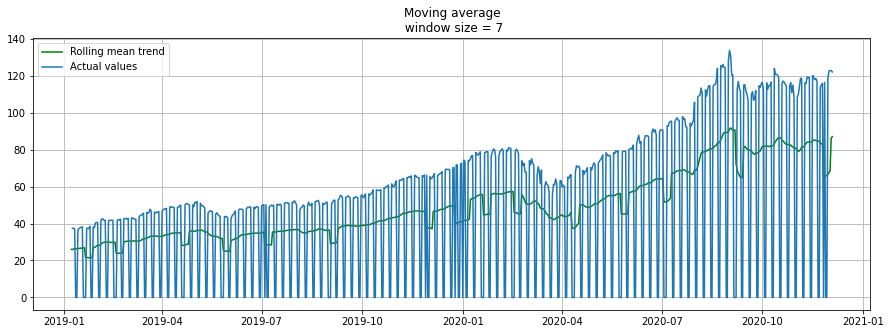

In [6]:
plotMovingAverage(df['Adj Close'], 7)

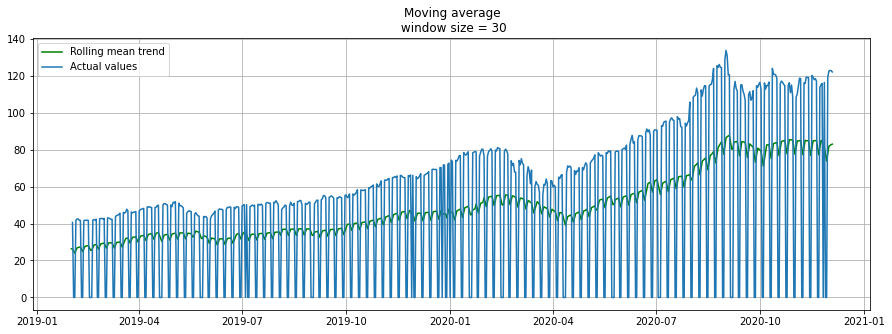

In [7]:
plotMovingAverage(df['Adj Close'], 30)

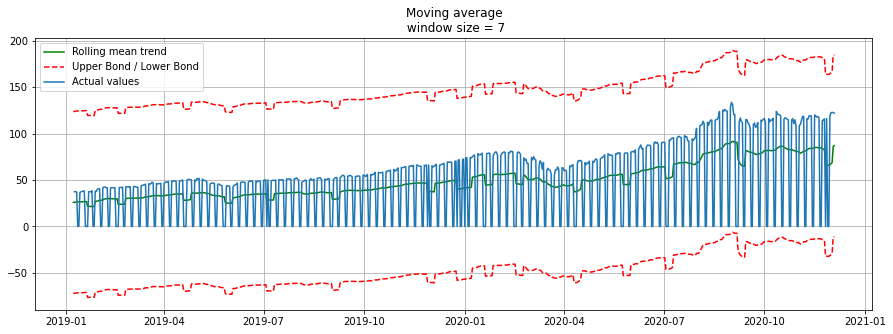

In [8]:
plotMovingAverage(df['Adj Close'], 7, plot_intervals=True)

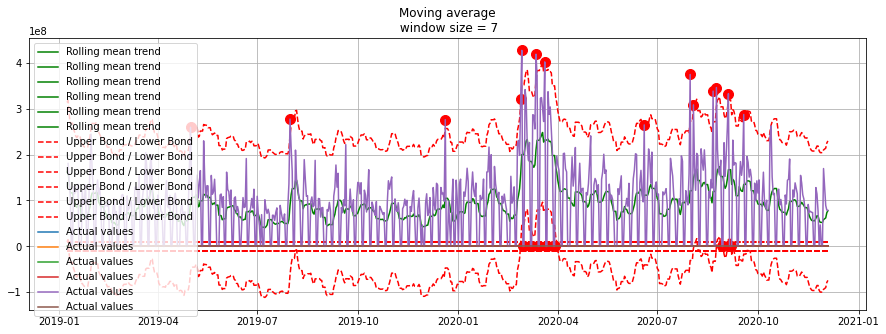

In [9]:
plotMovingAverage(df, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

In [10]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [11]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

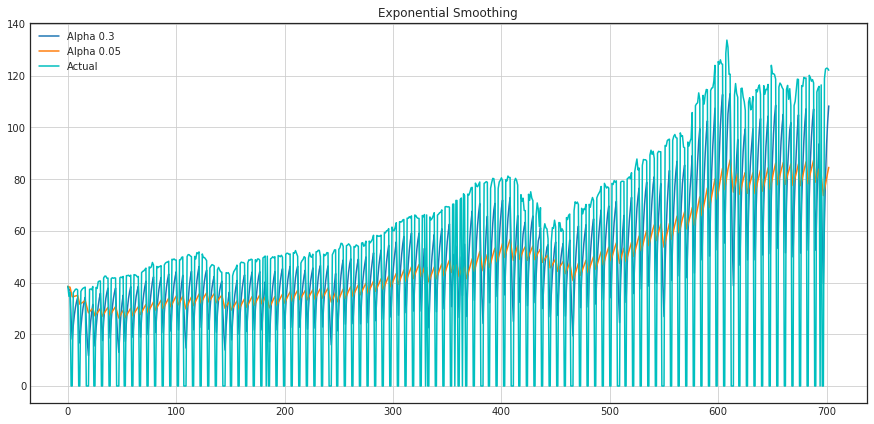

In [12]:
plotExponentialSmoothing(df['Adj Close'], [0.3, 0.05])

In [13]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

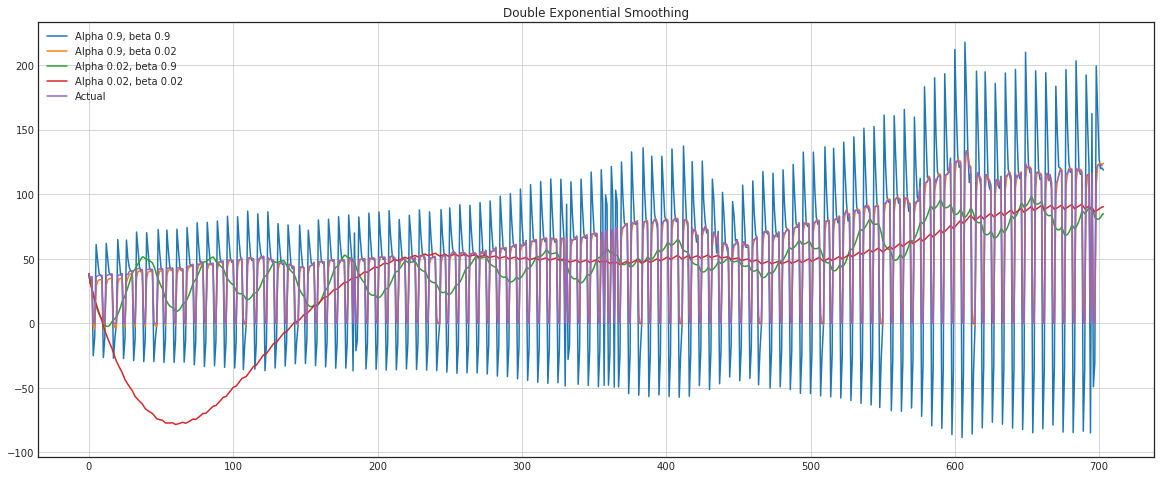

In [14]:
plotDoubleExponentialSmoothing(df['Adj Close'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [15]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [16]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [17]:
%%time
data = df['Adj Close'][:-20] # leave some data for testing
slen = 7 # 7-day seasonality

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 100 days
model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.0 0.0 0.11461168939077349
Wall time: 3.81 s


In [18]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

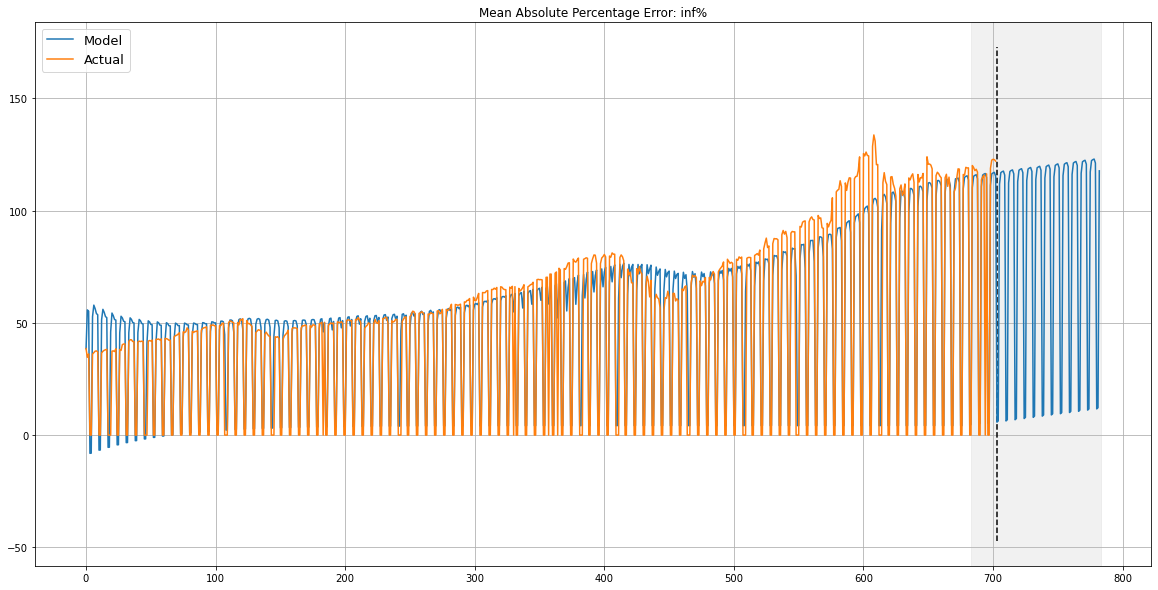

In [19]:
plotHoltWinters(df['Adj Close'])

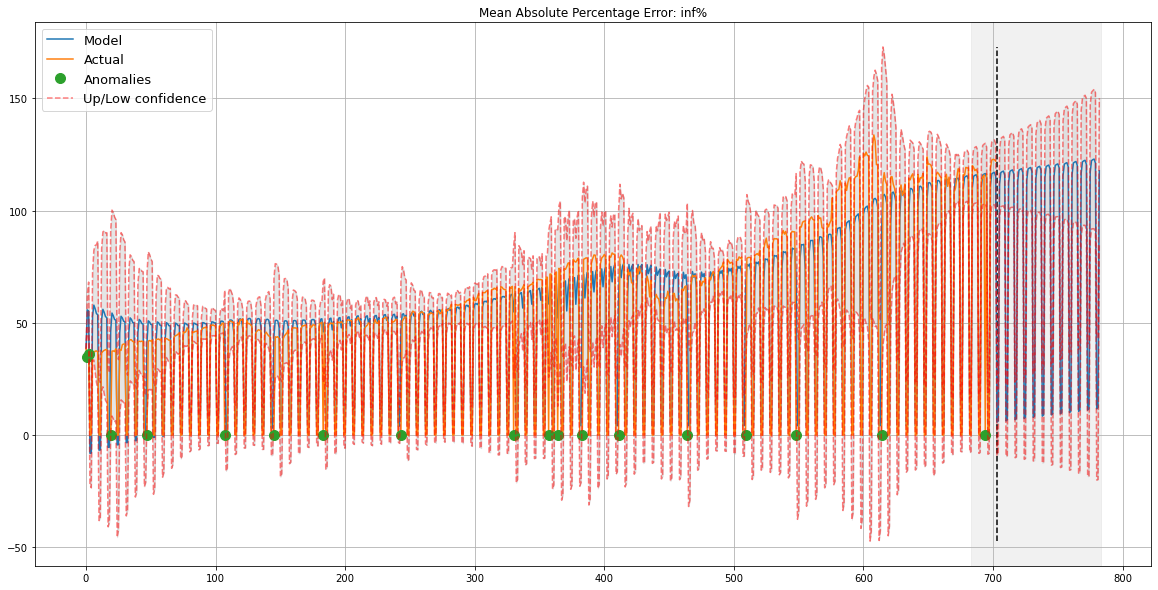

In [20]:
plotHoltWinters(df['Adj Close'], plot_intervals=True, plot_anomalies=True)

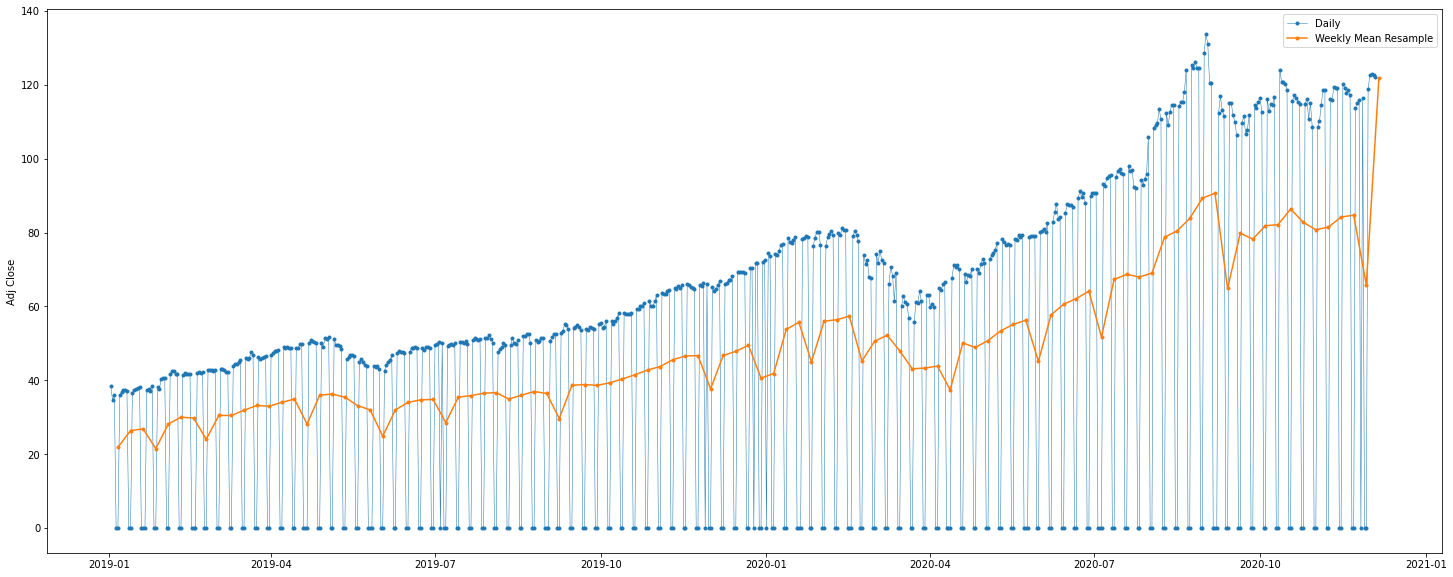

In [21]:
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(adj_close,marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(adj_close.resample('W').mean(),marker='o', markersize=3, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

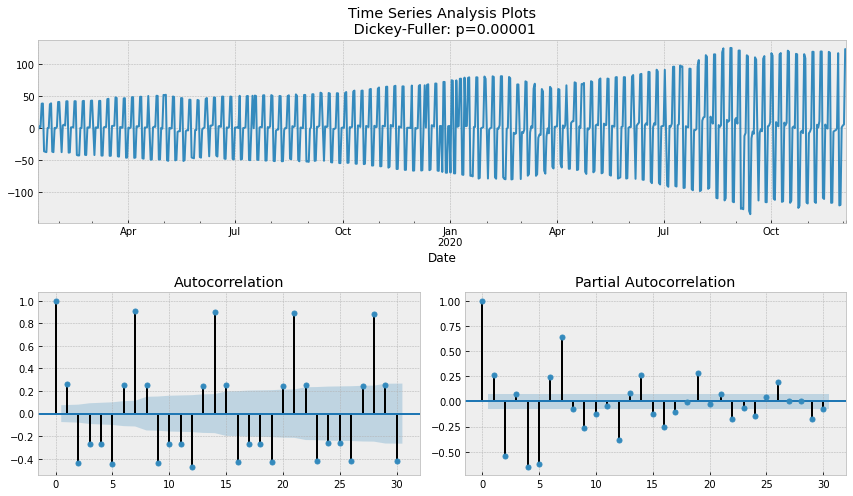

In [23]:
ads_diff = df['Adj Close'] - df['Adj Close'].shift(12)
tsplot(ads_diff[12:], lags=30)

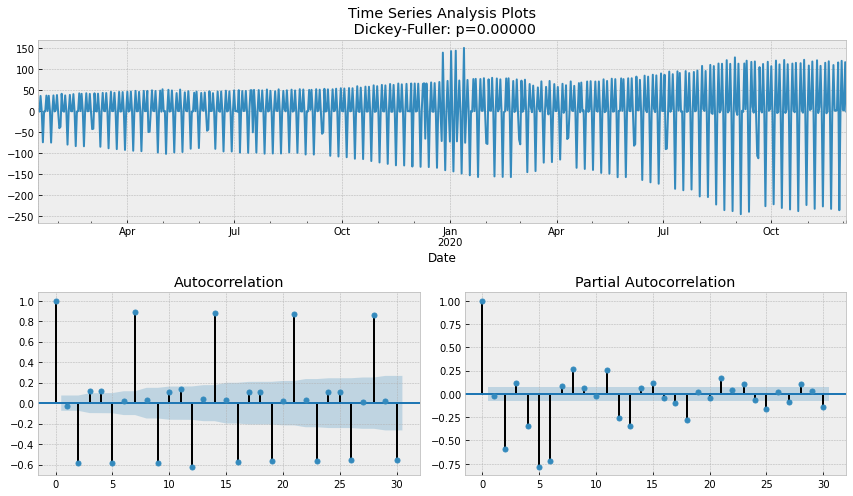

In [24]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[12+1:], lags=30)

In [25]:
# Set the y_to_train, y_to_test, and the length of predict units
y_to_train = adj_close[:'2020-05-01'] # dataset to train
y_to_val = df['Adj Close']['2020-06-01':] # last X months for test  
predict_date = len(df['Adj Close']) - len(df['Adj Close'][:'2020-06-01']) # the number of data points for the test set

In [26]:
def sarima_grid_search(adj_close, seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(adj_close,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [27]:
# %%time
# sarima_grid_search(df['Adj Close'], 60)

The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(1, 1, 1, 60) - AIC:5879.8815027427445
Wall time: 22min 15s


In [28]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(adj_close, order,seasonal_order, seasonal_period, pred_date, y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(df['Adj Close'],
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = df['Adj Close'].plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(25, 10))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Adj Close')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = df['Adj Close'].plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(25, 10))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Adj Close')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4551      0.069     -6.565      0.000      -0.591      -0.319
ma.L1          0.8349      0.039     21.559      0.000       0.759       0.911
ar.S.L60      -0.6533      0.072     -9.098      0.000      -0.794      -0.513
ma.S.L60      -0.1852      0.079     -2.340      0.019      -0.340      -0.030
sigma2      1424.3436     91.098     15.635      0.000    1245.794    1602.893
The Root Mean Squared Error of SARIMA with season_length=60 and dynamic = False 50.41


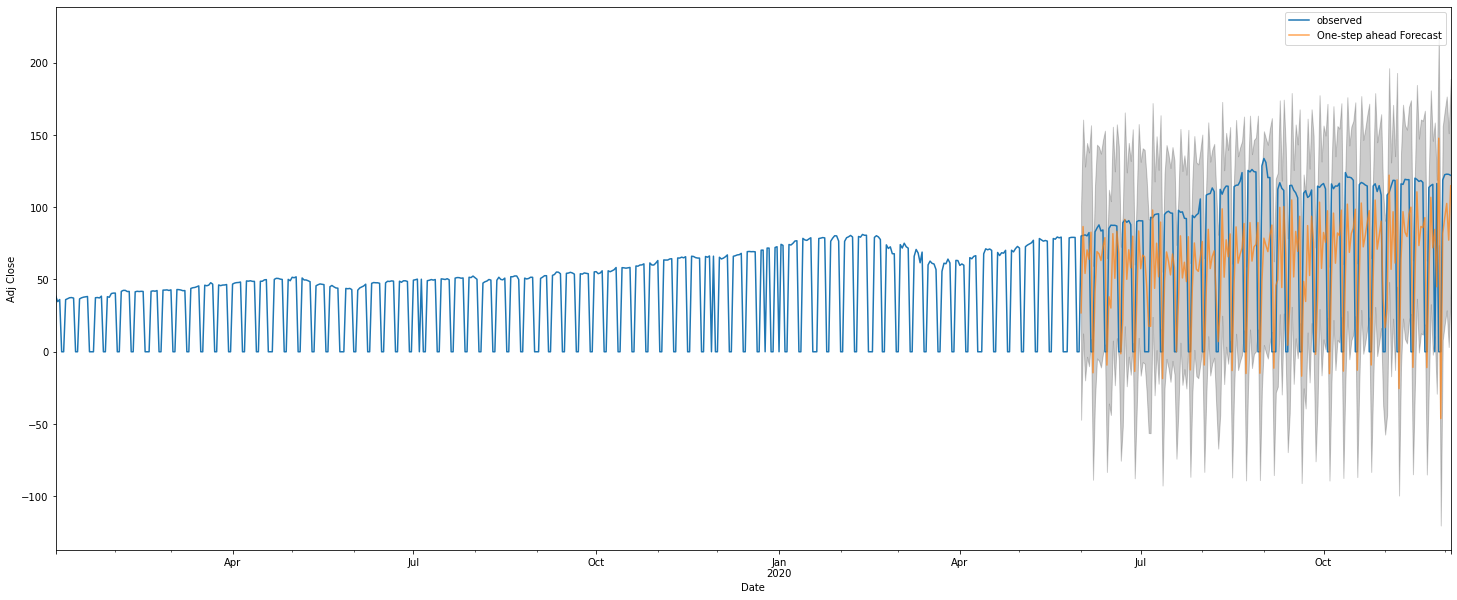

The Root Mean Squared Error of SARIMA with season_length=60 and dynamic = True 61.38


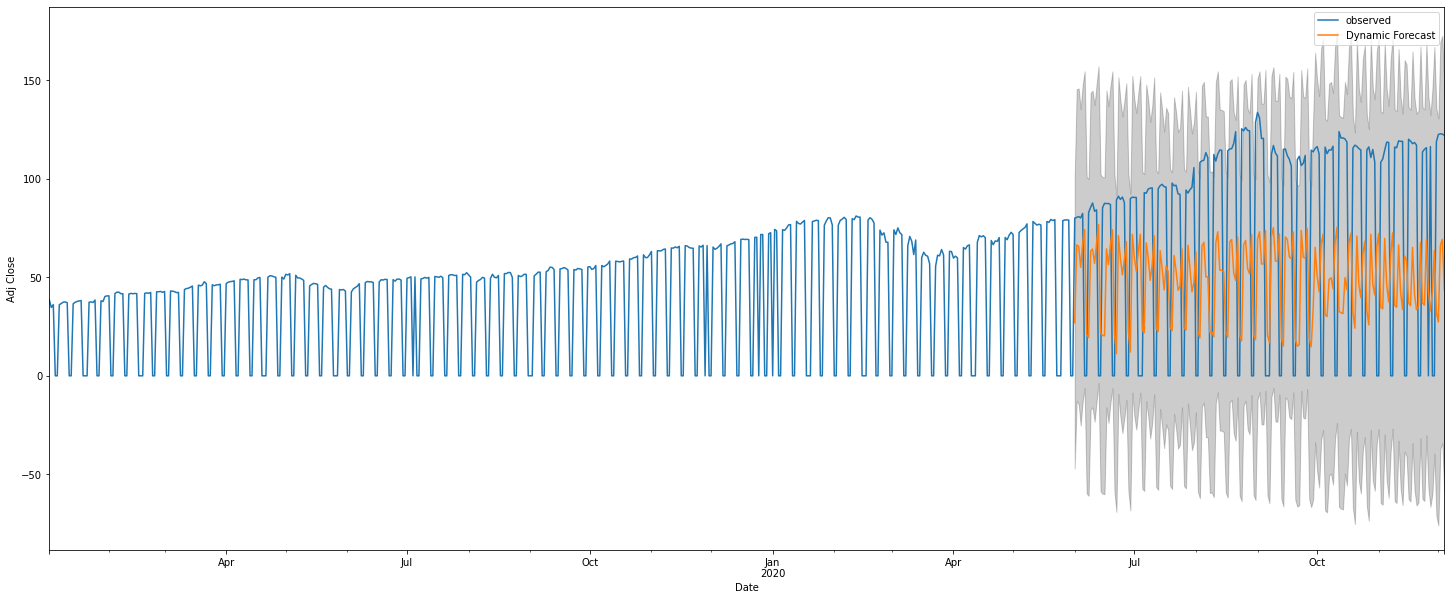

In [29]:
model = sarima_eva(df['Adj Close'], (1, 0, 1), (1, 1, 1, 60), 60, '2020-06-01', y_to_val)

In [30]:
def forecast(model, predict_steps, adj_close):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    # SARIMAXResults.conf_int, can change alpha,the default alpha = 0.05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = adj_close.plot(label='observed', figsize=(25, 10))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(adj_close.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

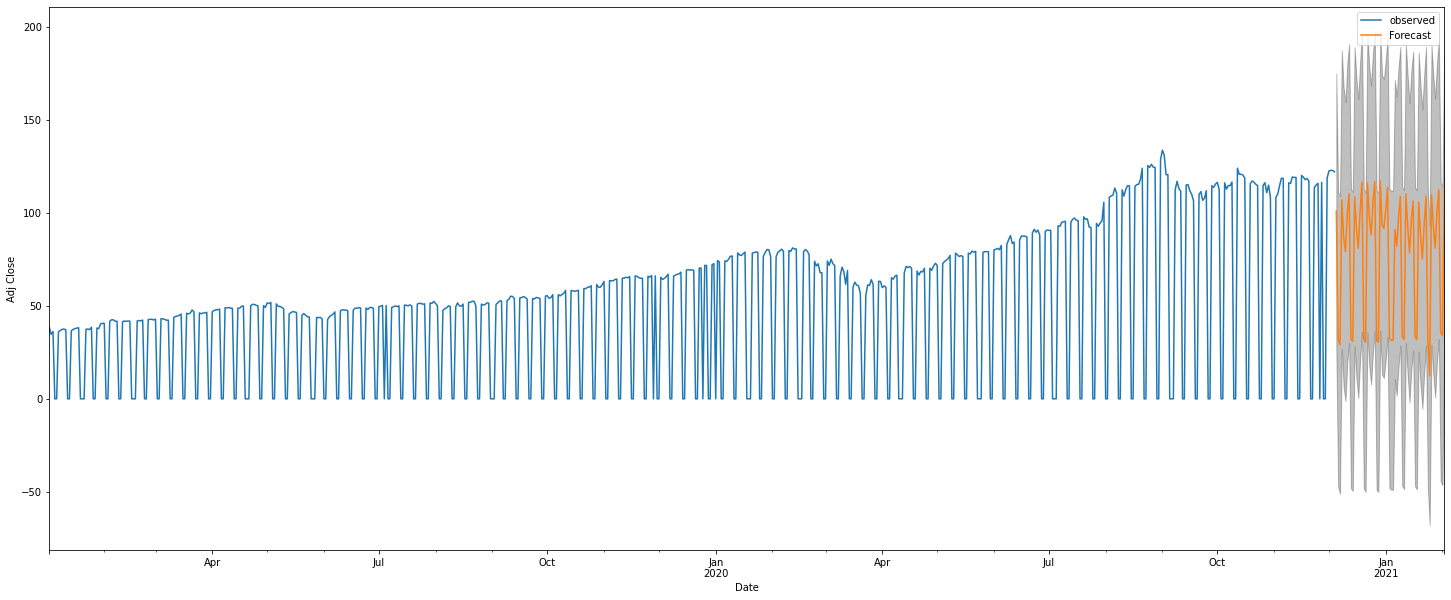

Date  Predicted_Mean  Lower Bound  Upper Bound
0 2020-12-05      100.981912    27.011937   174.951887
1 2020-12-06       32.041009   -47.084779   111.166796
2 2020-12-07       28.988651   -51.163489   109.140791
3 2020-12-08      107.008430    26.645366   187.371495
4 2020-12-09       86.875899     6.469220   167.282578

In [31]:
final_table = forecast(model, 60, df['Adj Close'])
final_table.head()

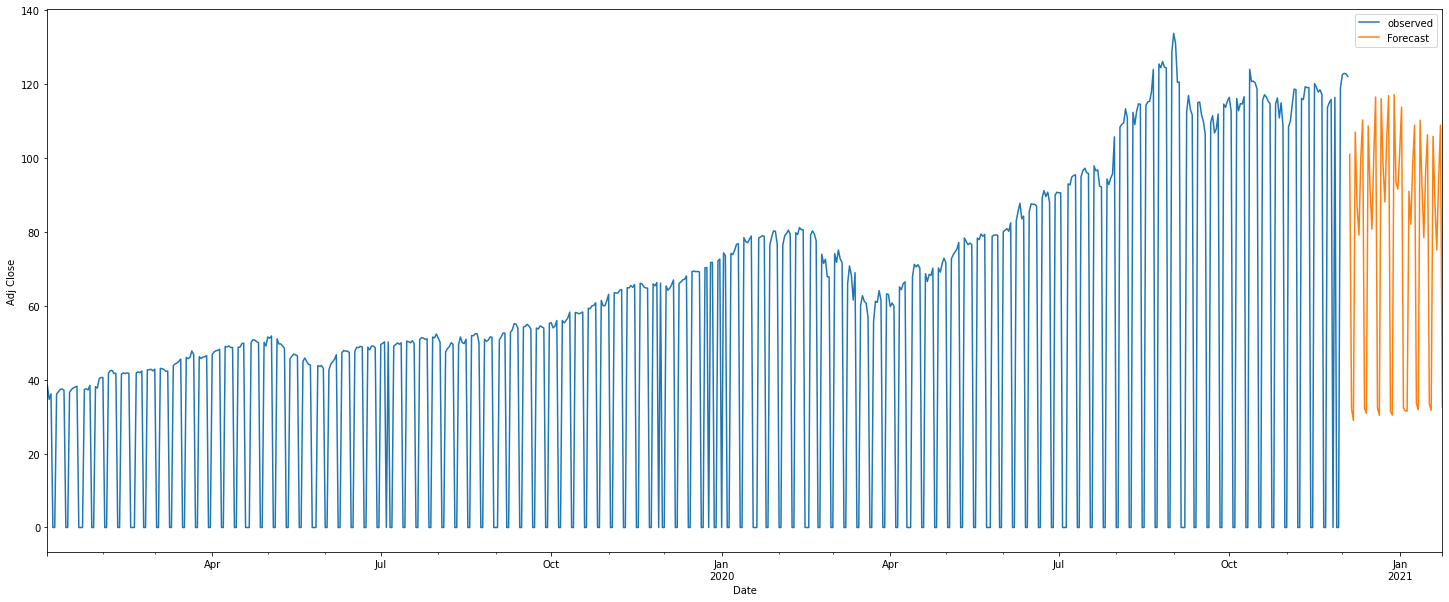

In [32]:
# Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = df['Adj Close'].plot(label='observed', figsize=(25, 10))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(df['Adj Close'].name)

plt.legend()
plt.show()

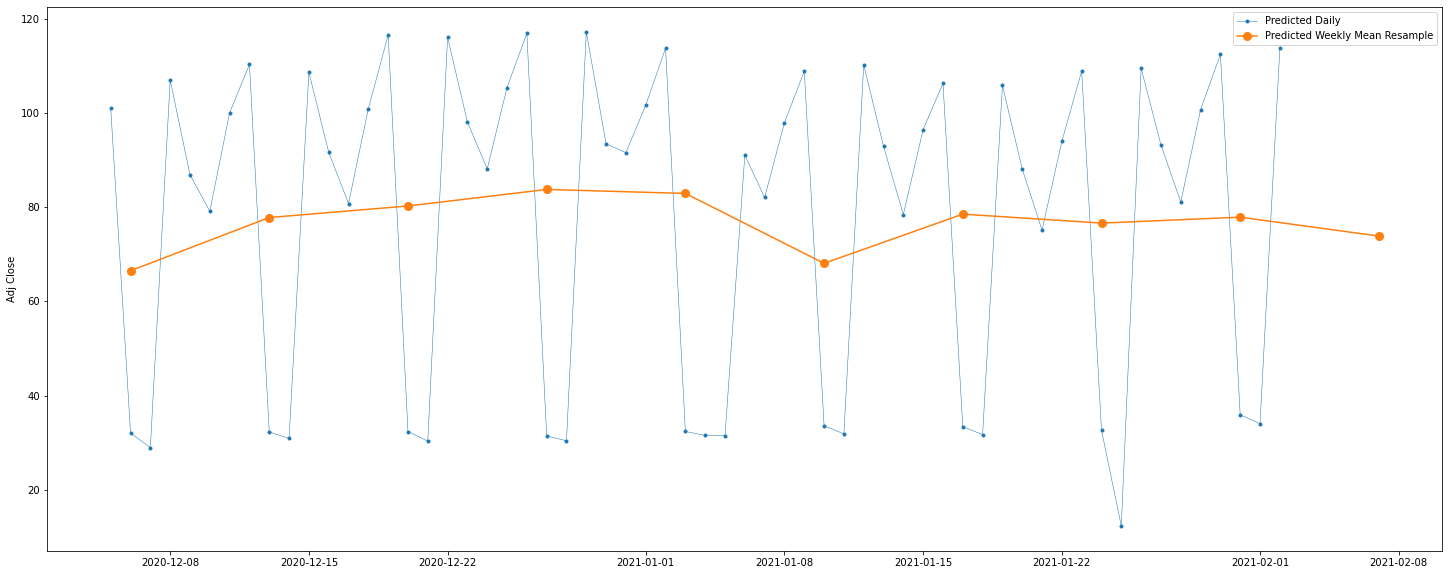

In [33]:
# Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots(figsize=(25, 10))
# ax.plot(df['Adj Close'],marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean, marker='.', linestyle='-', linewidth=0.5, label='Predicted Daily')
# ax.plot(df['Adj Close'].resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('W').mean(), marker='o', markersize=8, linestyle='-', label='Predicted Weekly Mean Resample')
ax.set_ylabel('Adj Close')
ax.legend();

# Linear

In [34]:
# Creating a copy of the initial dataframe to make various transformations 
data = pd.DataFrame(adj_close.copy())
data.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 30
for i in range(6, 30):
    data["lag_{}".format(i)] = data.y.shift(i)
    
data.tail()

y       lag_6       lag_7       lag_8       lag_9  \
Date                                                                     
2020-11-30  118.872368  114.998154  113.680122    0.000000    0.000000   
2020-12-01  122.536896  115.856873  114.998154  113.680122    0.000000   
2020-12-02  122.896355    0.000000  115.856873  114.998154  113.680122   
2020-12-03  122.756569  116.416031    0.000000  115.856873  114.998154   
2020-12-04  122.067596    0.000000  116.416031    0.000000  115.856873   

                lag_10      lag_11      lag_12      lag_13      lag_14  ...  \
Date                                                                    ...   
2020-11-30  117.164917  118.462982  117.853889  119.211861  120.120506  ...   
2020-12-01    0.000000  117.164917  118.462982  117.853889  119.211861  ...   
2020-12-02    0.000000    0.000000  117.164917  118.462982  117.853889  ...   
2020-12-03  113.680122    0.000000    0.000000  117.164917  118.462982  ...   
2020-12-04  114.998154  113.680122    0.000000    0.000000  117.164917  ...   

                lag_20      lag_21      lag_22      lag_23      lag_24  \
Date                                                                     
2020-11-30  115.796967  116.146439    0.000000    0.000000  118.512909   
2020-12-01  119.311707  115.796967  116.146439    0.000000    0.000000   
2020-12-02  119.032127  119.311707  115.796967  116.146439    0.000000   
2020-12-03  119.082054  119.032127  119.311707  115.796967  116.146439   
2020-12-04    0.000000  119.082054  119.032127  119.311707  115.796967   

                lag_25      lag_26      lag_27      lag_28      lag_29  
Date                                                                    
2020-11-30  118.647697  114.580803  110.085289  108.420654    0.000000  
2020-12-01  118.512909  118.647697  114.580803  110.085289  108.420654  
2020-12-02    0.000000  118.512909  118.647697  114.580803  110.085289  
2020-12-03    0.000000    0.000000  118.512909  118.647697  114.580803  
2020-12-04  116.146439    0.000000    0.000000  118.512909  118.647697  

[5 rows x 25 columns]

In [35]:
# for time-series cross-validation set 7 folds 
tscv = TimeSeriesSplit(n_splits=7)

In [36]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [37]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 10% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [38]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [39]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

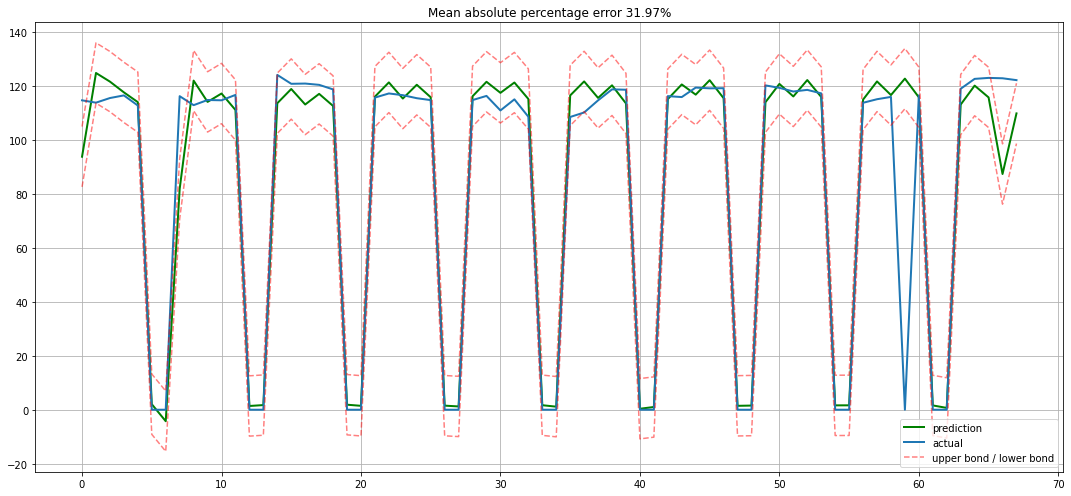

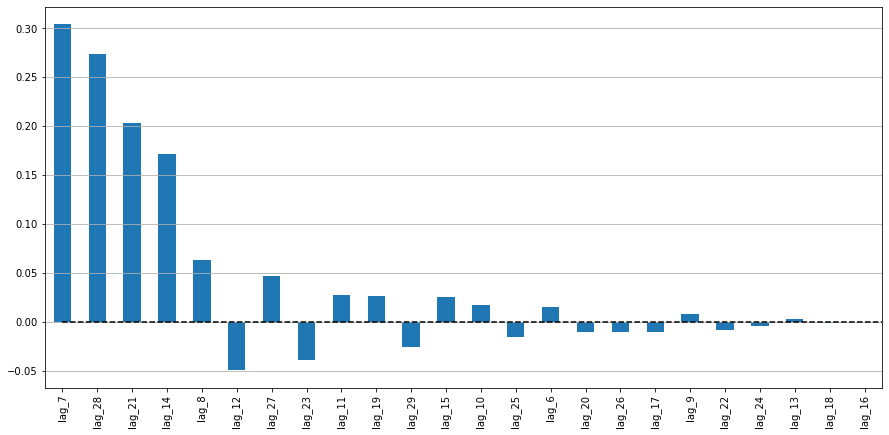

In [40]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [41]:
data.index = pd.to_datetime(data.index)
data["weekday"] = data.index.weekday
# 5 and 6 index = weekends
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

y       lag_6       lag_7       lag_8       lag_9  \
Date                                                                     
2020-11-30  118.872368  114.998154  113.680122    0.000000    0.000000   
2020-12-01  122.536896  115.856873  114.998154  113.680122    0.000000   
2020-12-02  122.896355    0.000000  115.856873  114.998154  113.680122   
2020-12-03  122.756569  116.416031    0.000000  115.856873  114.998154   
2020-12-04  122.067596    0.000000  116.416031    0.000000  115.856873   

                lag_10      lag_11      lag_12      lag_13      lag_14  ...  \
Date                                                                    ...   
2020-11-30  117.164917  118.462982  117.853889  119.211861  120.120506  ...   
2020-12-01    0.000000  117.164917  118.462982  117.853889  119.211861  ...   
2020-12-02    0.000000    0.000000  117.164917  118.462982  117.853889  ...   
2020-12-03  113.680122    0.000000    0.000000  117.164917  118.462982  ...   
2020-12-04  114.998154  113.680122    0.000000    0.000000  117.164917  ...   

                lag_22      lag_23      lag_24      lag_25      lag_26  \
Date                                                                     
2020-11-30    0.000000    0.000000  118.512909  118.647697  114.580803   
2020-12-01  116.146439    0.000000    0.000000  118.512909  118.647697   
2020-12-02  115.796967  116.146439    0.000000    0.000000  118.512909   
2020-12-03  119.311707  115.796967  116.146439    0.000000    0.000000   
2020-12-04  119.032127  119.311707  115.796967  116.146439    0.000000   

                lag_27      lag_28      lag_29  weekday  is_weekend  
Date                                                                 
2020-11-30  110.085289  108.420654    0.000000        0           0  
2020-12-01  114.580803  110.085289  108.420654        1           0  
2020-12-02  118.647697  114.580803  110.085289        2           0  
2020-12-03  118.512909  118.647697  114.580803        3           0  
2020-12-04    0.000000  118.512909  118.647697        4           0  

[5 rows x 27 columns]

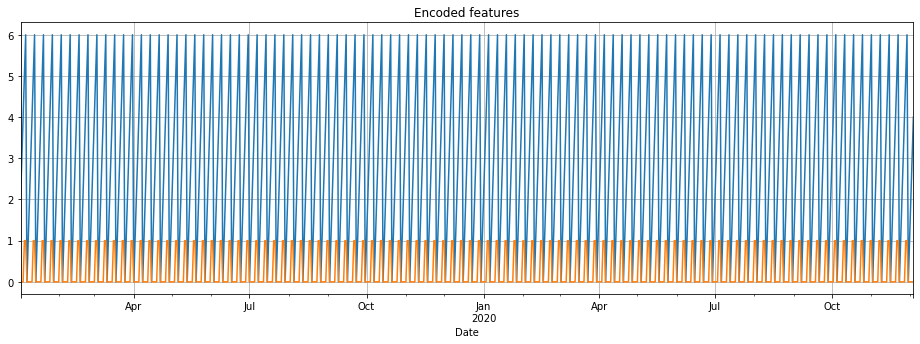

In [42]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

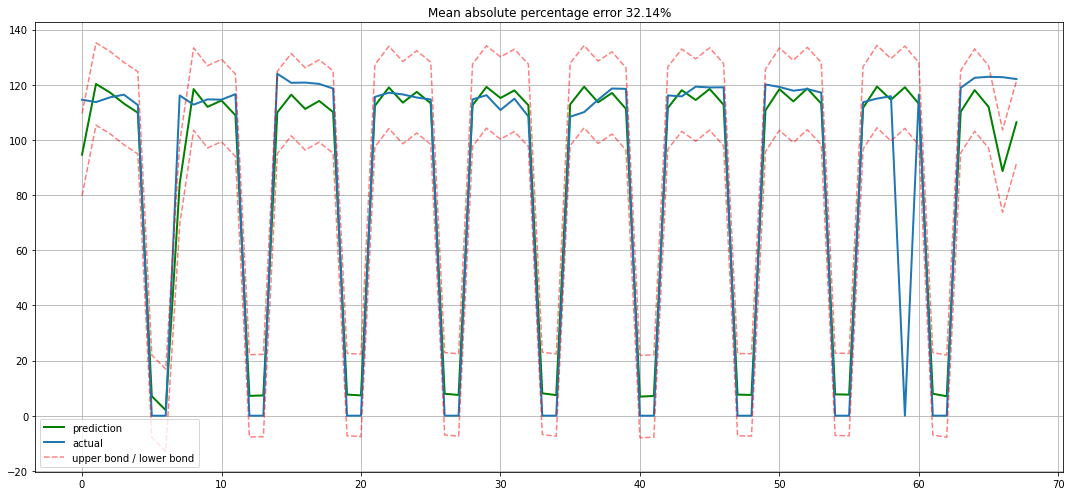

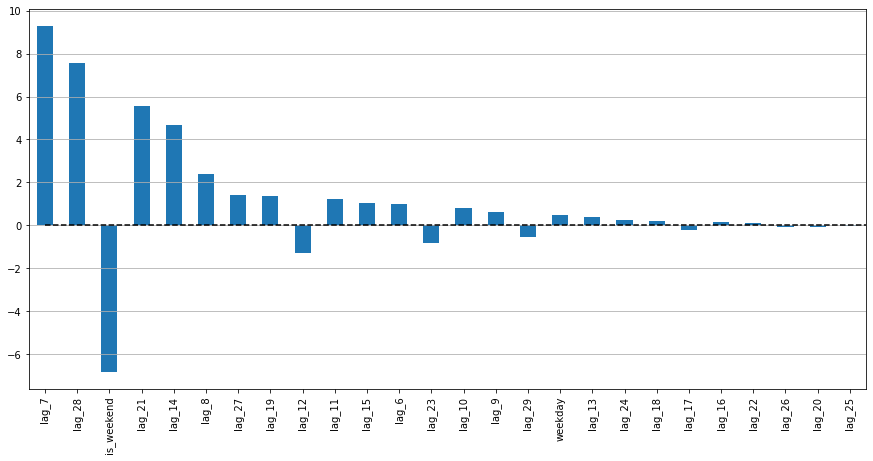

In [43]:
scaler = StandardScaler()
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [44]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

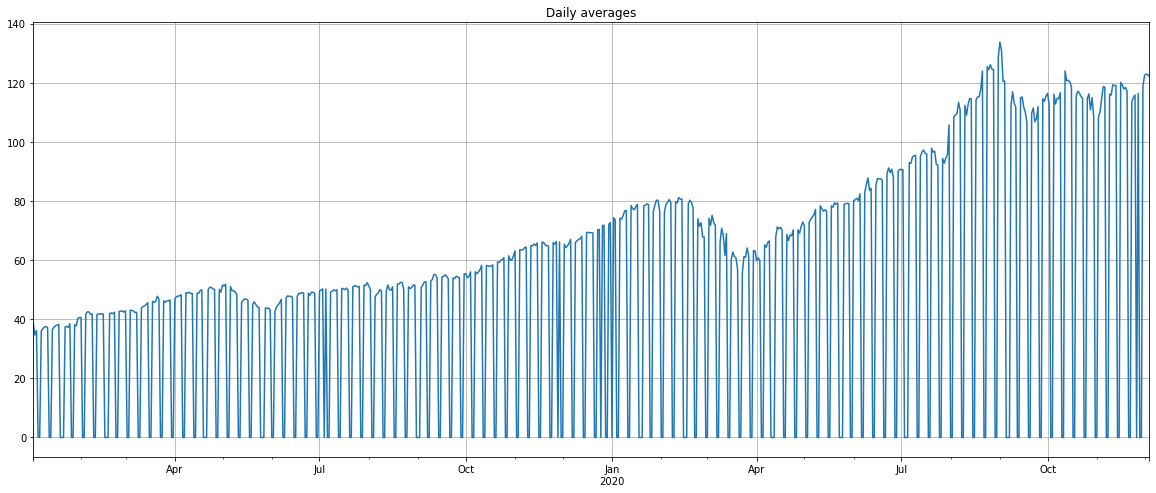

In [45]:
average_date = code_mean(data, 'Date', "y")
plt.figure(figsize=(20, 8))
plt.title("Daily averages")
pd.DataFrame.from_dict(average_date, orient='index')[0].plot()
plt.grid(True);

In [46]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

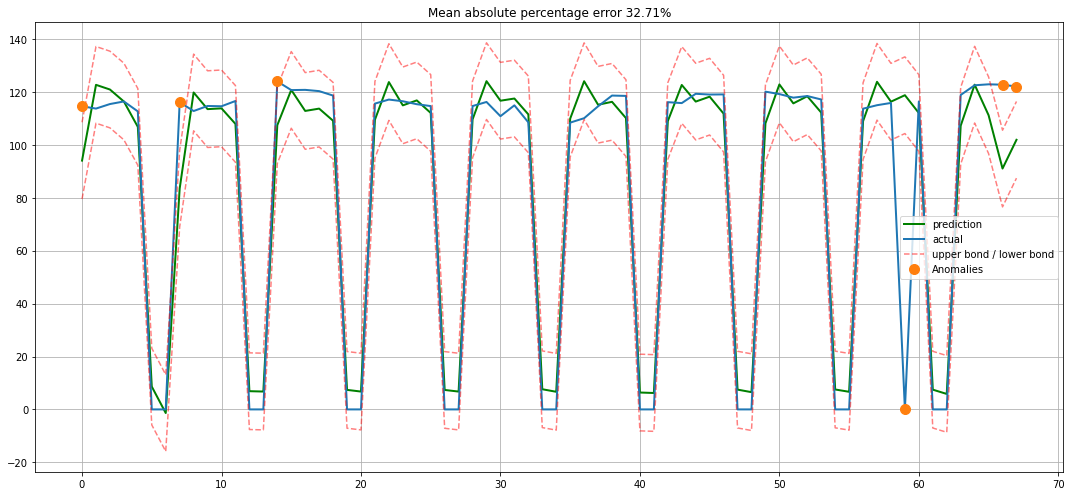

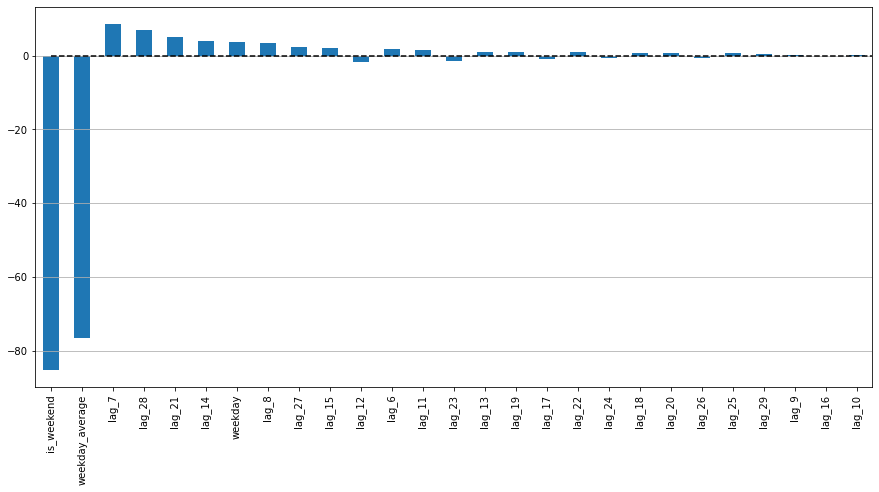

In [47]:
X_train, X_test, y_train, y_test =\
prepareData(adj_close, lag_start=6, lag_end=30, test_size=0.1, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [48]:
X_train, X_test, y_train, y_test =\
prepareData(adj_close, lag_start=6, lag_end=30, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

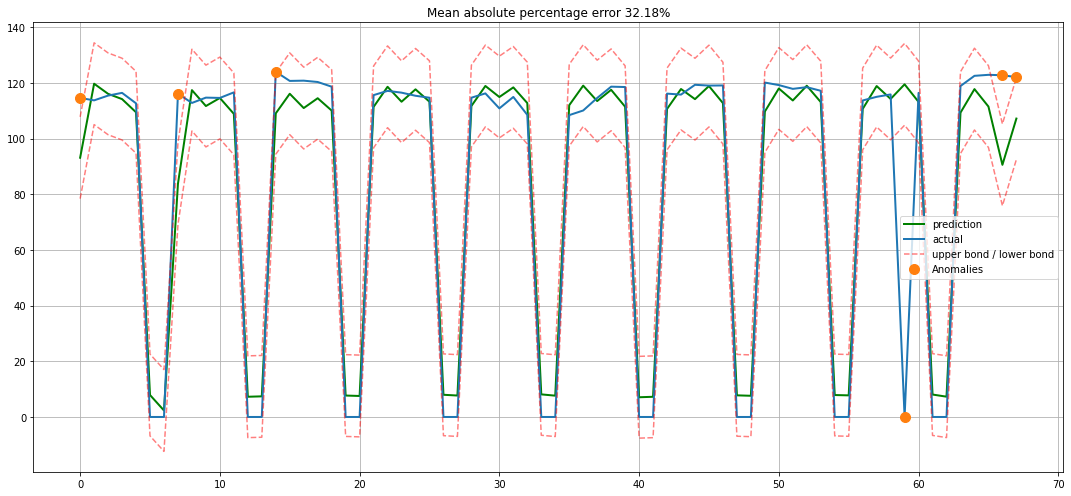

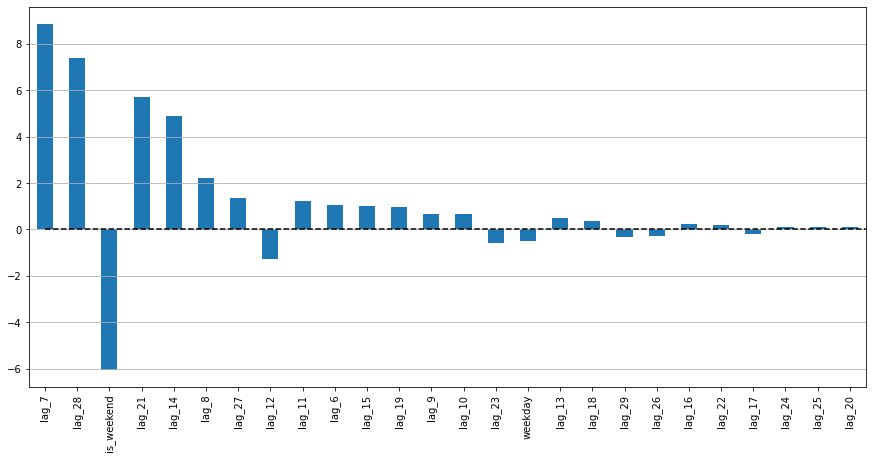

In [50]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

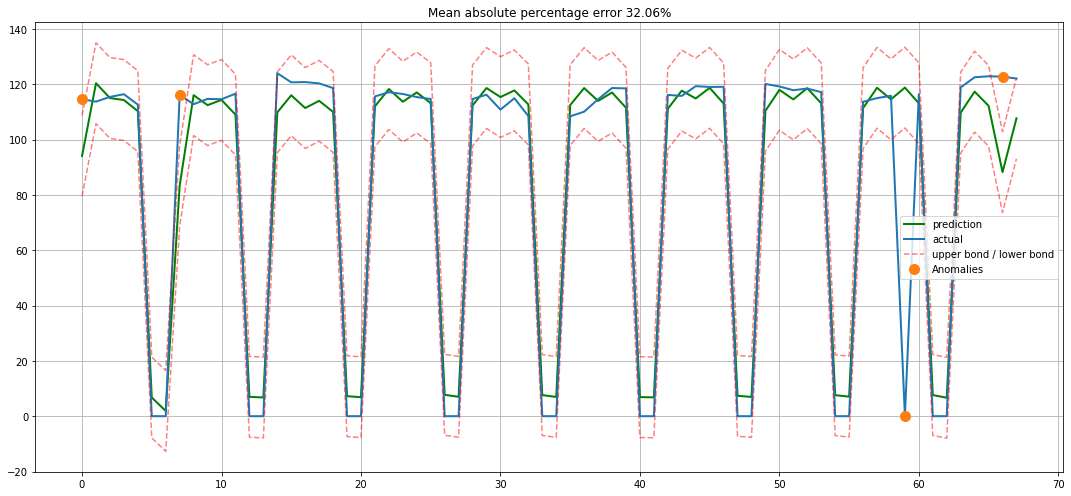

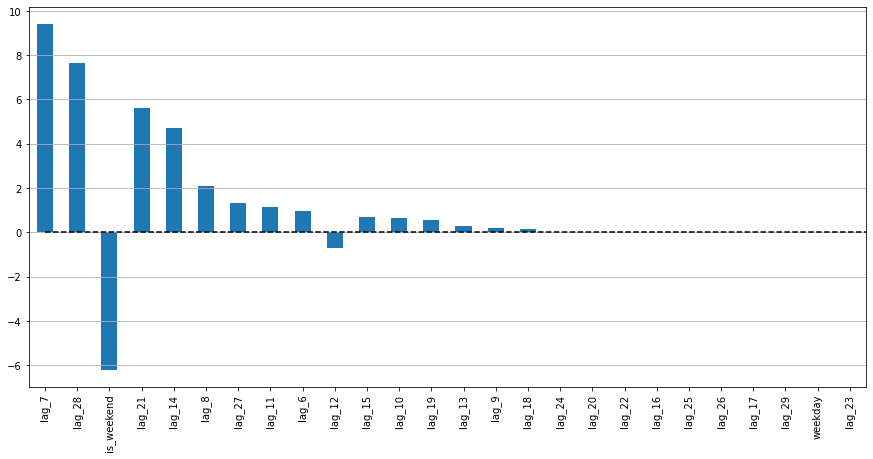

In [51]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

### Boosting

In [52]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

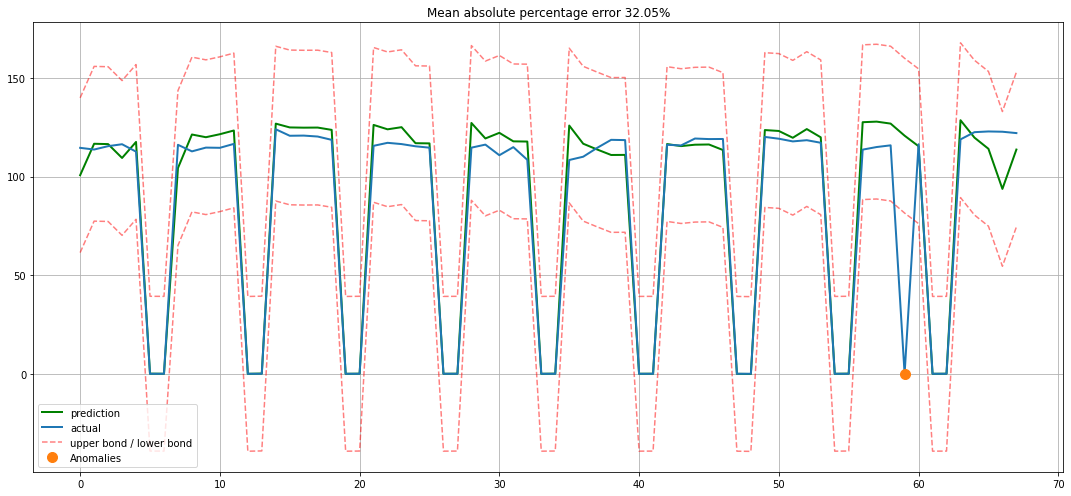

In [53]:
plotModelResults ( xgb ,  
                 X_train = X_train_scaled ,  
                 X_test = X_test_scaled ,  
                 plot_intervals = True ,  plot_anomalies = True )

In [54]:
###